# Algorithmic Fairness, Accountability, and Ethics, Spring 2025

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [1]:
# Importing libraries 
# the basic ones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data import
from folktables.acs import adult_filter
from folktables import ACSDataSource

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# performance
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve
import shap

from scipy.interpolate import interp1d

c:\Users\Mikas\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100] # total person's income
    df = df[df['WKHP'] > 0] 
    df = df[df['PWGTP'] >= 1]
    df = df[df["SCHL"]>=15] # added school from 15 years, so account for adults
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

## Task 1

Starting from the template, train two different classifiers on the training data: 
- a white-box model using logistic regression, 
- and a black-box model using a random forest.

Describe the feature engineering and scaling steps you took to train the classifiers (e.g. standardization of features is a good idea for the logistic regression model) and summarize the steps in your report. 

For both models, report on the accuracy of the classifier on the test set.

In [3]:
# logistic regression
# standardization
# Define the scaler
scaler = ColumnTransformer([("scaler", StandardScaler(), ["AGEP"])], remainder="passthrough")
# Create the pipeline
logistic_model = Pipeline(steps=[
    ("scaler", scaler),
    ("logi", LogisticRegression(max_iter=5000, penalty="l2", C=0.8497534359086438, tol=1e-4, solver="saga"))
])
# Fit the model
logistic_model.fit(X_train, y_train)
# Transform the data
X_train_scaled = logistic_model["scaler"].transform(X_train)
X_test_scaled = logistic_model["scaler"].transform(X_test)
# Predictions
log_y_pred = logistic_model.predict(X_test)
log_y_prob = logistic_model.predict_proba(X_test)[:, 1]


In [4]:

log_accuracy = accuracy_score(y_test, log_y_pred)
log_accuracy

0.7679558011049724

In [5]:
# Random forest classifier

forest = RandomForestClassifier(max_depth = 5, random_state=23, n_jobs=-1, n_estimators=20)
forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test)
forest_y_prob = forest.predict_proba(X_test)[:, 1]

In [6]:

forest_accuracy = accuracy_score(y_test, forest_y_pred)
forest_accuracy

0.7604677903356984

Additionally checked feature importacne

In [7]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


In [8]:
feature_names = X_train.columns

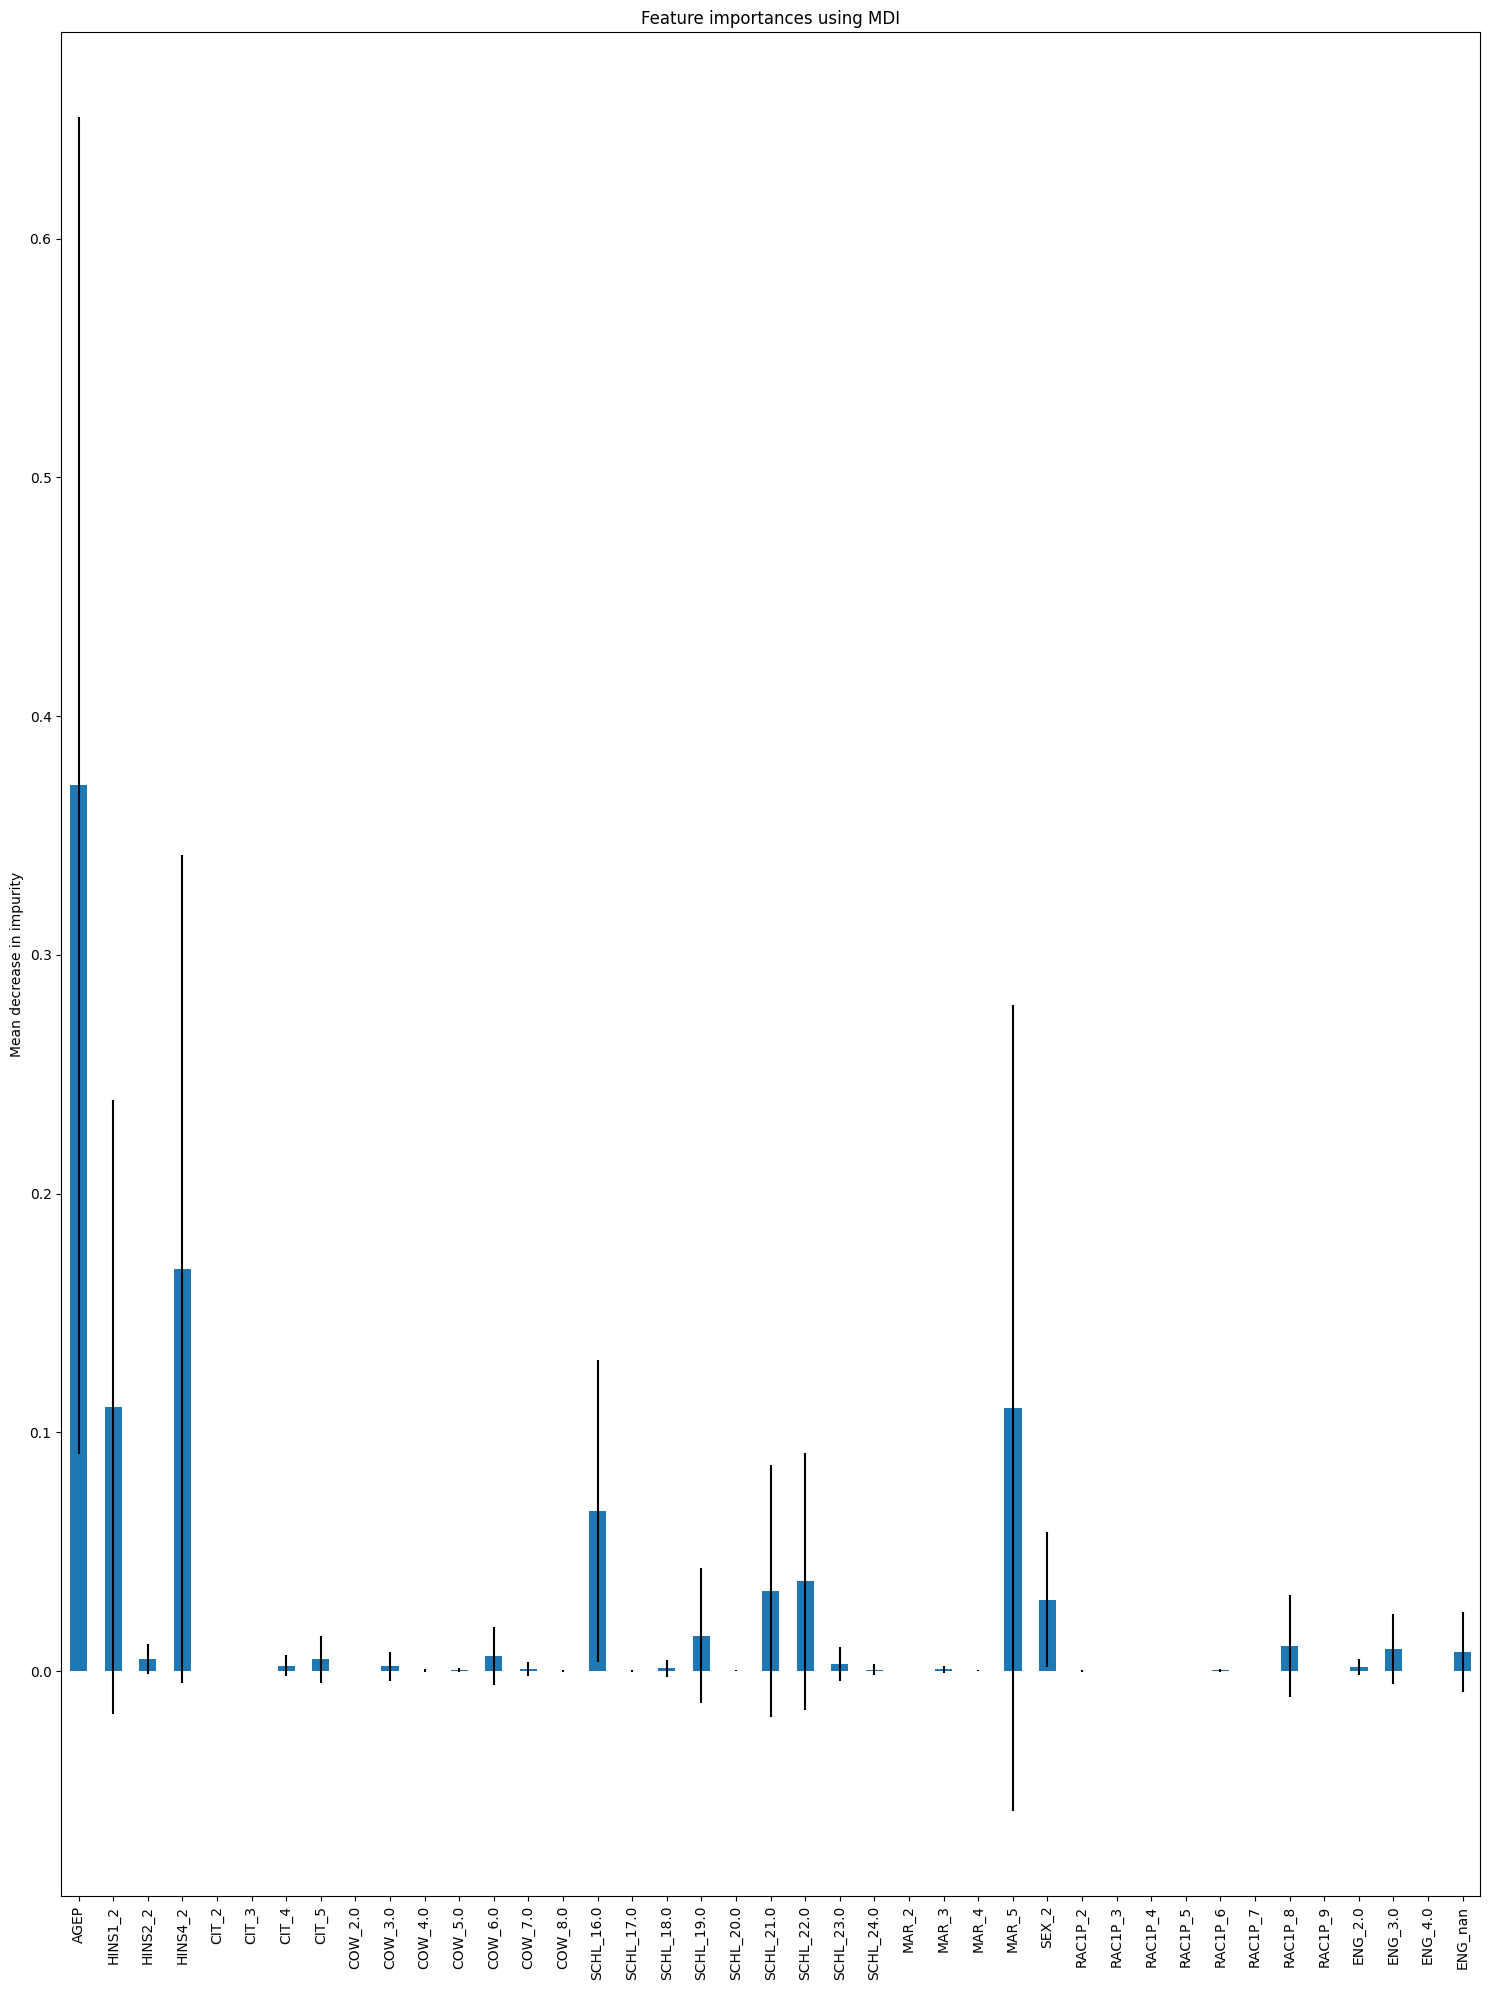

In [9]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Is it fair?

For each classifier, measure statistical parity and equalized odds (both in
terms of T = 0 and T (see Lecture 2). Plot the results and discuss the
differences that you observe.

In [10]:
def stat_parity(pred):
    group1 = np.mean(pred[group_test == 1]) 
    group2 = np.mean(pred[group_test == 2]) 
    return group1, group2

def equal_odds(pred, target):
    group1 = np.mean(pred[(y_test == target) & (group_test == 1)])
    group2 = np.mean(pred[(y_test == target) & (group_test == 2)])
    return group1, group2

def fairness(pred):
    scores = [stat_parity(pred), 
           equal_odds(pred, 0), 
           equal_odds(pred, 1)]
    names = ["stat_parity",
                "eq_odds_t0",
                "eq_odds_t1"]
    df_fair_metrics = pd.DataFrame({"score":[], "metric" : [], "group":[]})
    for i in range(len(names)):
        g1,g2 = scores[i]
        new_metrics = {"score":[g1, g2], "metric" : [names[i], names[i]], "group":["male", "female"]}
        df_fair_metrics = pd.concat([df_fair_metrics, pd.DataFrame(new_metrics)], ignore_index=True)
    
    return df_fair_metrics

log_fairness = fairness(log_y_pred)
forest_fairness = fairness(forest_y_pred)

print(log_fairness)
print()
print(forest_fairness)


      score       metric   group
0  0.686121  stat_parity    male
1  0.568182  stat_parity  female
2  0.352081   eq_odds_t0    male
3  0.319463   eq_odds_t0  female
4  0.873530   eq_odds_t1    male
5  0.798254   eq_odds_t1  female

      score       metric   group
0  0.726494  stat_parity    male
1  0.692223  stat_parity  female
2  0.407871   eq_odds_t0    male
3  0.464981   eq_odds_t0  female
4  0.905253   eq_odds_t1    male
5  0.902428   eq_odds_t1  female


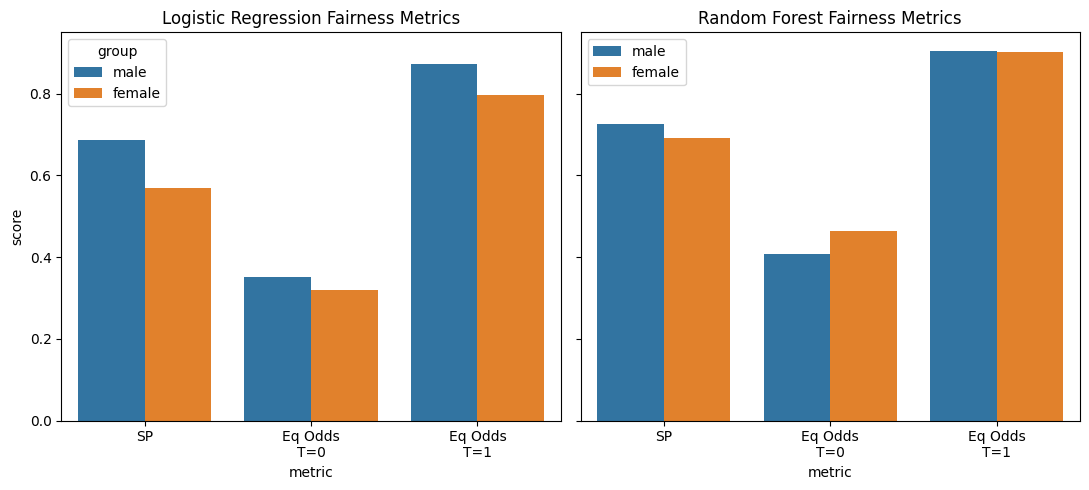

In [11]:
def plot_fairness(log, forest):
    _, ax = plt.subplots(1,2, figsize=(11,5), sharey=True)

    sns.barplot(data = log,
                x = 'metric',
                y = 'score',
                hue = 'group',
                ax=ax[0]
                )

    sns.barplot(data = forest,
                x = 'metric',
                y = 'score',
                hue= 'group',
                ax=ax[1]
                )

    plt.legend()
    ax[0].set_title("Logistic Regression Fairness Metrics")
    ax[1].set_title("Random Forest Fairness Metrics")

    ax[0].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])
    ax[1].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])

    plt.tight_layout()

    plt.show()

plot_fairness(log_fairness, forest_fairness)

### Make it fair
Change the classification pipeline to (approximately) fulfill one of the
fairness criteria by post-processing the results (e.g. either statistical parity
or equalized odds). How did the intervention influence the different
fairness criteria, how did it change the accuracy of the classification?

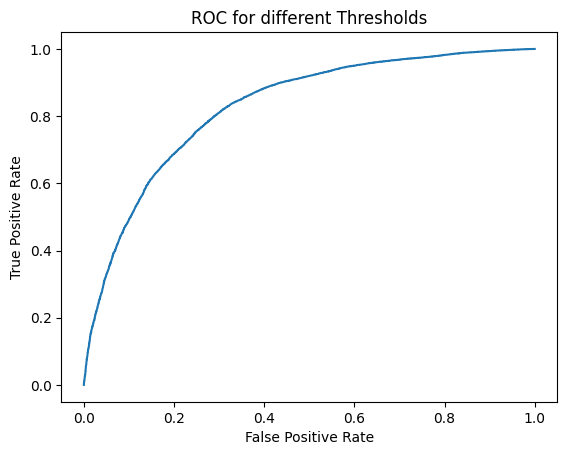

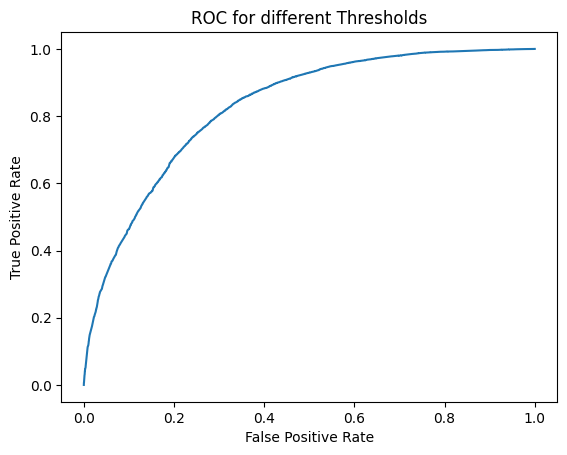

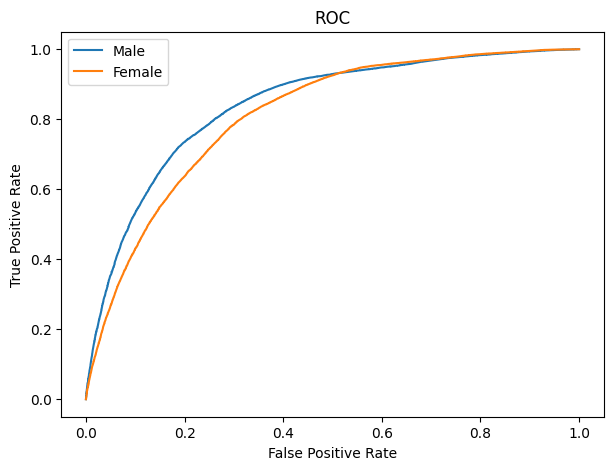

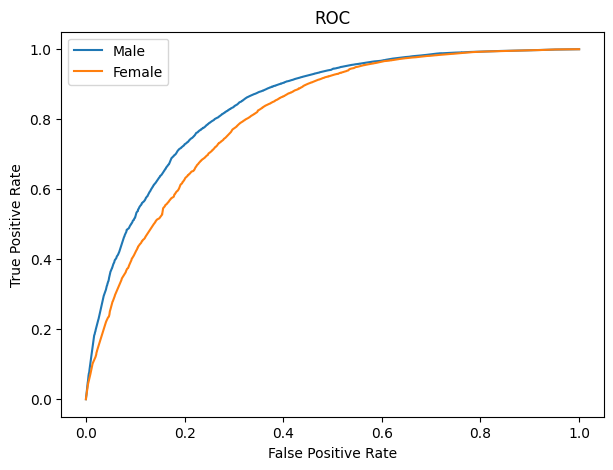

0.7931292101503142 0.7444197252599221


In [12]:
def  roc_curve_generator(test, prob): 
    # Compute ROC curve 
    #false positive rate, true positive rate, threshold
    fpr, tpr, thr = roc_curve(test, prob, drop_intermediate=False)

    # Plot it
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set_title("ROC for different Thresholds")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")

def  roc_curve_generator_groups(test_1, prob_1, test_2, prob_2): 
    fpr_1, tpr_1, thr_1 = roc_curve(test_1, prob_1, drop_intermediate=False)
    fpr_2, tpr_2, thr_2 = roc_curve(test_2, prob_2, drop_intermediate=False)

    tpr_diff = []
    fpr_diff = []
    thresholds = []
    for p in np.arange(0.1, 0.99, 0.001):
        tpr_diff.append(abs(tpr_1[tpr_1>p][0] - tpr_2[tpr_2>p][0]))
        fpr_diff.append(abs(fpr_1[tpr_1>p][0] - fpr_2[tpr_2>p][0]))
        thresholds.append((thr_1[tpr_1>p][0], thr_2[tpr_2>p][0]))

    diffs = []
    for i in range(len(fpr_diff)):
        diffs.append(abs(fpr_diff[i] - tpr_diff[i]))

    n = np.argmin(diffs)

    thr_group1, thr_group2 = thresholds[n]


    #plot
    _, ax = plt.subplots(1,1, figsize=(7,5))

    ax.plot(fpr_1, tpr_1, label='Male')
    ax.plot(fpr_2, tpr_2, label='Female')

    ax.set_title("ROC")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    plt.legend()
    plt.show()
    return thr_group1, thr_group2

roc_curve_generator(y_test, log_y_prob)
roc_curve_generator(y_test, forest_y_prob)

# separate ROC for each group
log_y_prob_group1 = logistic_model.predict_proba(X_train[group_train==1])[:,1]
log_y_prob_group2 = logistic_model.predict_proba(X_train[group_train==2])[:,1]
log_thr_group1, log_thr_group2 = roc_curve_generator_groups(y_train[group_train==1], log_y_prob_group1, y_train[group_train==2], log_y_prob_group2)

forest_y_prob_group1 = forest.predict_proba(X_train[group_train==1])[:,1]
forest_y_prob_group2 = forest.predict_proba(X_train[group_train==2])[:,1]
forest_thr_group1, forest_thr_group2 = roc_curve_generator_groups(y_train[group_train==1], forest_y_prob_group1, y_train[group_train==2], forest_y_prob_group2)


print(forest_thr_group1, forest_thr_group2)



0.7443419244468127 0.5203185910199961
      score       metric   group
0  0.779277  stat_parity    male
1  0.732504  stat_parity  female
2  0.506182   eq_odds_t0    male
3  0.521713   eq_odds_t0  female
4  0.932493   eq_odds_t1    male
5  0.927492   eq_odds_t1  female

      score       metric   group
0  0.124695  stat_parity    male
1  0.130493  stat_parity  female
2  0.016888   eq_odds_t0    male
3  0.040402   eq_odds_t0  female
4  0.185179   eq_odds_t1    male
5  0.213830   eq_odds_t1  female


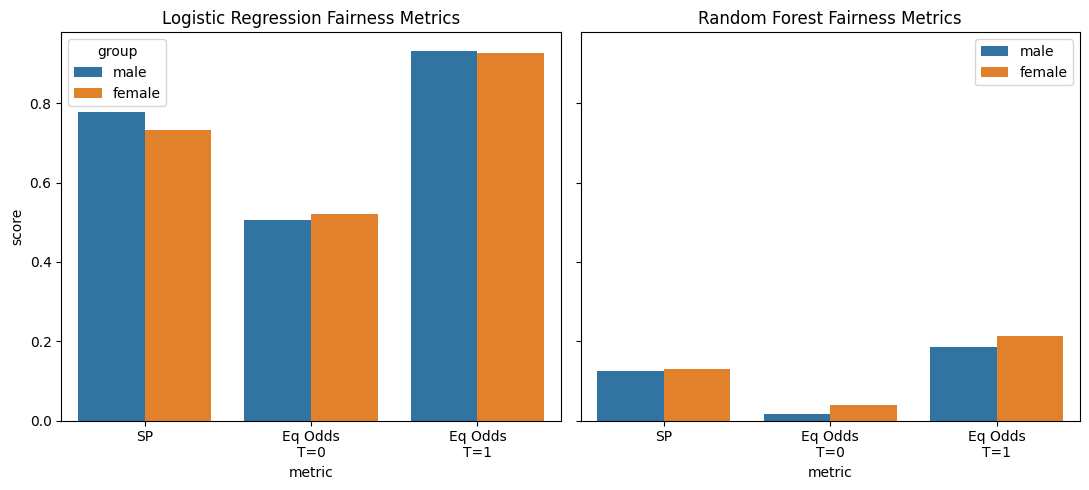

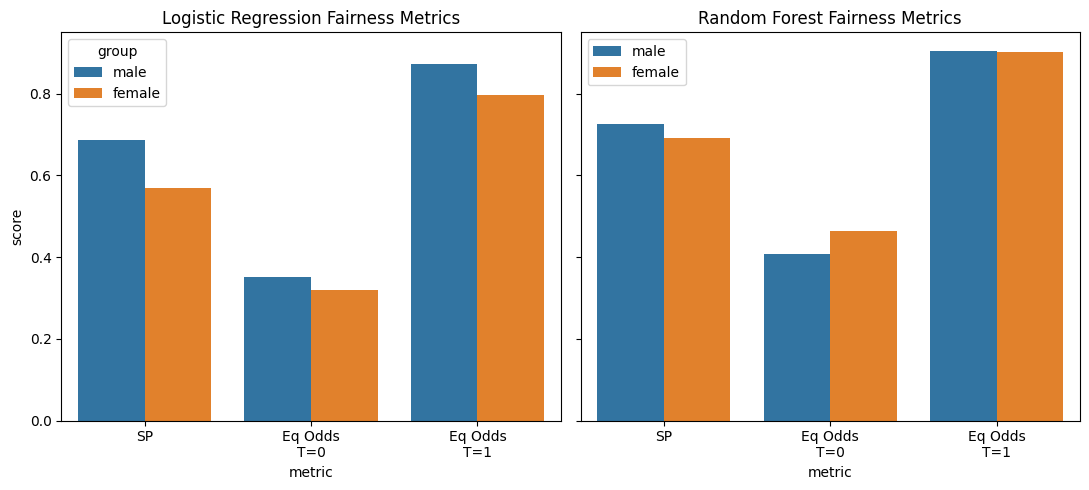

In [13]:
def new_accuracy(prob, thr_1, thr_2):    
    new_pred = []
    for i, y in list(enumerate(prob)):
        if not X_test['SEX_2'].iloc[i]:
            if y >= thr_1:
                new_pred.append(1)
            else:
                new_pred.append(0)
        else: 
            if y >= thr_2:
                new_pred.append(1)
            else:
                new_pred.append(0)
    new_y_pred = pd.DataFrame()
    new_y_pred['group_test'] = group_test
    new_y_pred['y_test'] = y_test
    new_y_pred['pred'] = new_pred

    stp_1 = np.mean(new_y_pred['pred'].where(new_y_pred['group_test'] == 1))
    stp_2 = np.mean(new_y_pred['pred'].where(new_y_pred['group_test'] == 2))
    eq_odds_T1_1 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 1).where(new_y_pred['group_test'] == 1))
    eq_odds_T1_2 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 1).where(new_y_pred['group_test'] == 2))
    eq_odds_T0_1 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 0).where(new_y_pred['group_test'] == 1))
    eq_odds_T0_2 = np.mean(new_y_pred['pred'].where(new_y_pred['y_test'] == 0).where(new_y_pred['group_test'] == 2))
    
    scores = [(stp_1,stp_2), 
           (eq_odds_T0_1,eq_odds_T0_2), 
           (eq_odds_T1_1,eq_odds_T1_2)]
    names = ["stat_parity",
                "eq_odds_t0",
                "eq_odds_t1"]
    df_fair_metrics = pd.DataFrame({"score":[], "metric" : [], "group":[]})
    for i in range(len(names)):
        g1,g2 = scores[i]
        new_metrics = {"score":[g1, g2], "metric" : [names[i], names[i]], "group":["male", "female"]}
        df_fair_metrics = pd.concat([df_fair_metrics, pd.DataFrame(new_metrics)], ignore_index=True)
    
    return accuracy_score(y_test, new_pred), df_fair_metrics

new_log_accuracy, new_log_fairness = new_accuracy(log_y_prob, log_thr_group1, log_thr_group2)
new_forest_accuracy, new_forest_fairness = new_accuracy(forest_y_prob, forest_thr_group1, forest_thr_group2)

print(new_log_accuracy, new_forest_accuracy)
print(new_log_fairness)
print()
print(new_forest_fairness)
plot_fairness(new_log_fairness, new_forest_fairness)
plot_fairness(log_fairness, forest_fairness)

0.7073505903469165


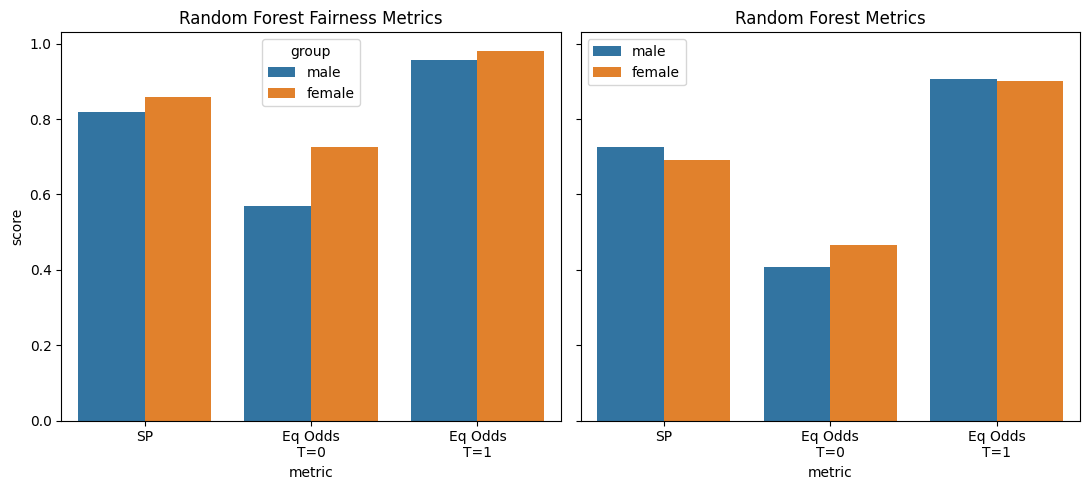

In [14]:
new_new_forest_accuracy, new_new_forest_fairness = new_accuracy(forest_y_prob, log_thr_group1, log_thr_group2)
print(new_new_forest_accuracy)

_, ax = plt.subplots(1,2, figsize=(11,5), sharey=True)

sns.barplot(data = new_new_forest_fairness,
                x = 'metric',
                y = 'score',
                hue = 'group',
                ax=ax[0]
                )

sns.barplot(data = forest_fairness,
                x = 'metric',
                y = 'score',
                hue = 'group',
                ax=ax[1]
                )


plt.legend()
ax[0].set_title("Random Forest Fairness Metrics")
ax[1].set_title("Random Forest Metrics")

ax[0].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])
ax[1].set_xticks([0,1,2], ['SP', f'Eq Odds\nT=0', f'Eq Odds\nT=1'])

plt.tight_layout()

plt.show()


## Task 2 – Explaining models using SHAP
Both for the white-box (logistic regression) and the black-box (random
forest) classifier, use the SHAP module to explain predictions. Contrast
the two models to each other: What are similarities, how do they differ?

In [ ]:
# logistic model

explainer_log = shap.Explainer(logistic_model["logi"], X_train_scaled, feature_names = np.array(X_train.columns))
shap_values_log = explainer_log(X_test_scaled)

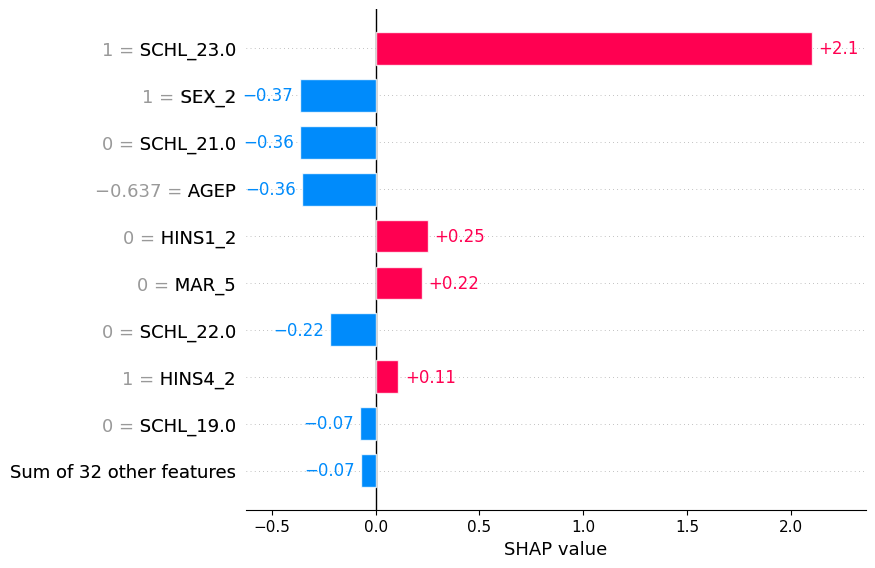

In [16]:
shap.plots.bar(shap_values_log[44])

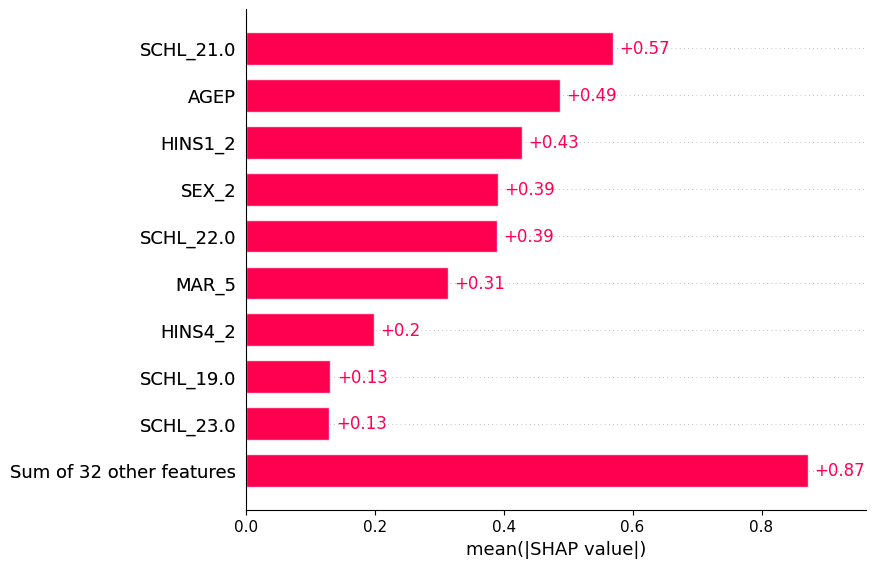

In [17]:
shap.plots.bar(shap_values_log)

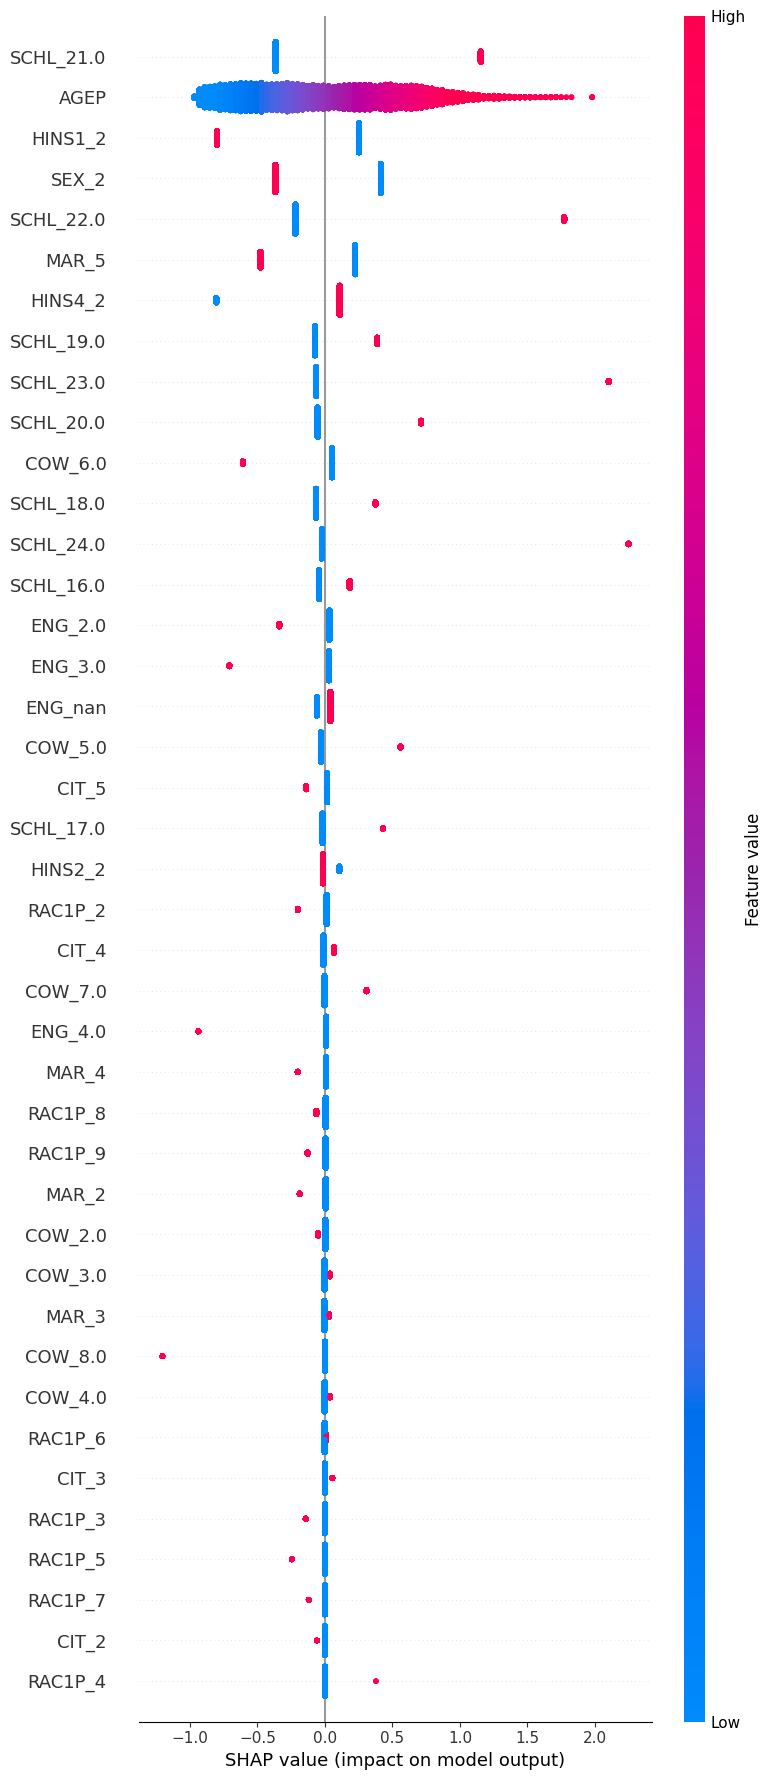

In [18]:
shap.summary_plot(shap_values_log, X_test_scaled, max_display=X_test_scaled.shape[1])

In [19]:
shap.initjs()
shap.force_plot(shap_values_log[44], link="logit")

In [ ]:
#repeat random forest

forest = RandomForestClassifier(max_depth = 5, random_state=23, n_jobs=-1, n_estimators=20)
forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test)
forest_y_prob = forest.predict_proba(X_test)[:, 1]

In [21]:
forest_accuracy = accuracy_score(y_test, forest_y_pred)
forest_accuracy

0.7604677903356984

In [23]:
explainer_tree = shap.TreeExplainer(forest, X_train.astype('float64'), feature_names = np.array(X_train.columns))


In [24]:
shap_values = explainer_tree.shap_values(X_test)

 98%|===================| 70034/71314 [00:33<00:00]        

In [25]:
shap_values_to_plot = shap_values[:, :, 1]

In [26]:
# Ensure base values selection for classification
base_value = explainer_tree.expected_value[1] if isinstance(explainer_tree.expected_value, list) else explainer_tree.expected_value


In [27]:
print("SHAP values shape:", shap_values_to_plot.shape)  # Should match X_test
print("X_test shape:", X_test.shape)


SHAP values shape: (35657, 41)
X_test shape: (35657, 41)


In [28]:
print("SHAP values shape:", shap_values_to_plot.shape)
print("X_test shape:", X_test.shape)
print("Feature names length:", len(feature_names))


SHAP values shape: (35657, 41)
X_test shape: (35657, 41)
Feature names length: 41


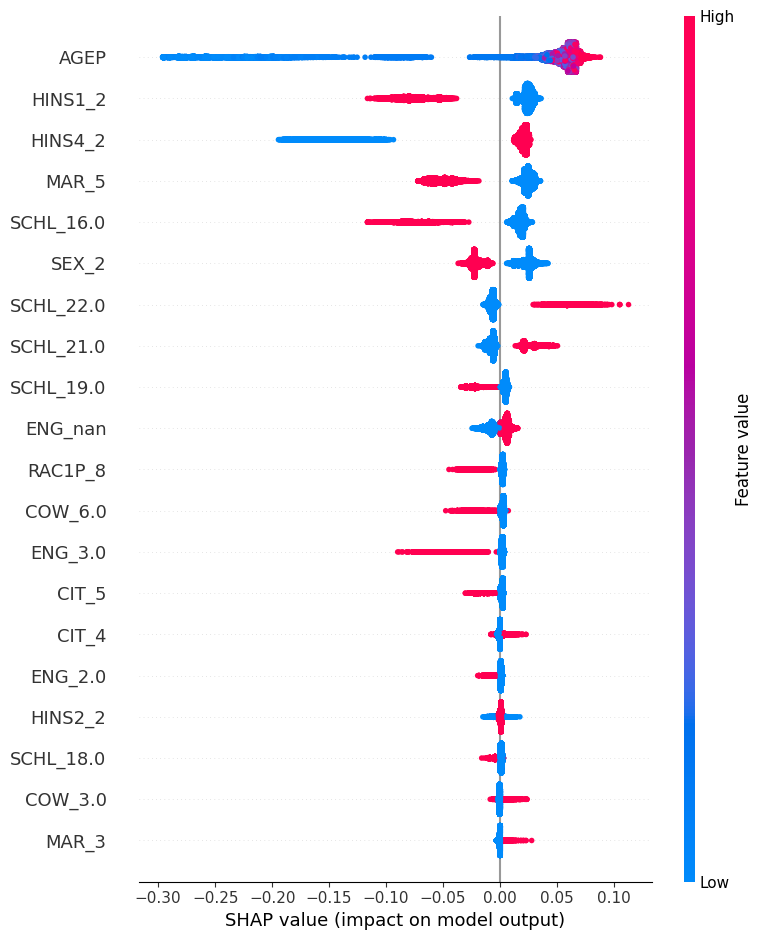

In [29]:
feature_names = np.array(X_test.columns)
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values_to_plot, X_test, feature_names=feature_names)

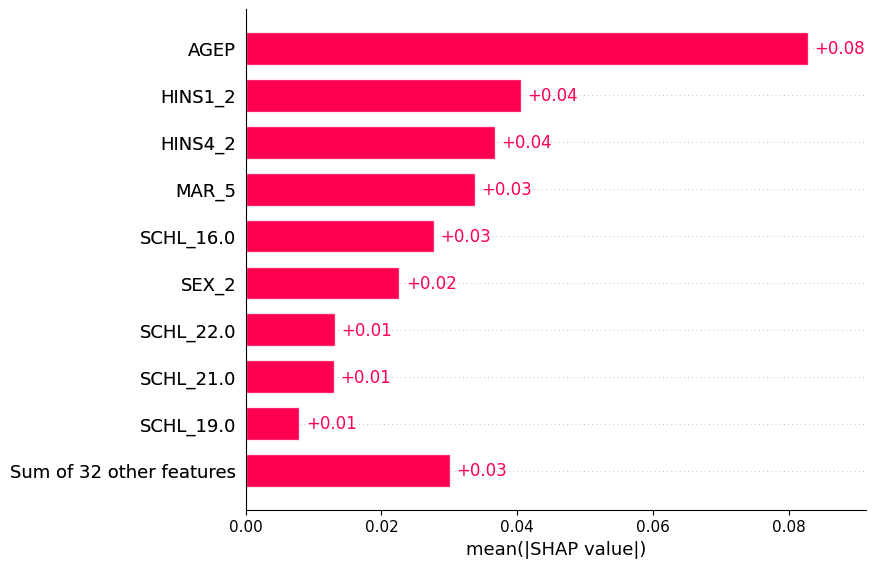

In [30]:
# Create SHAP explanation object
shap_exp = shap.Explanation(
    values=shap_values_to_plot,
    base_values=base_value,
    data=X_test,
    feature_names=feature_names
)

# ✅ Generate SHAP bar plot
plt.figure(figsize=(10, 7))
shap.plots.bar(shap_exp)


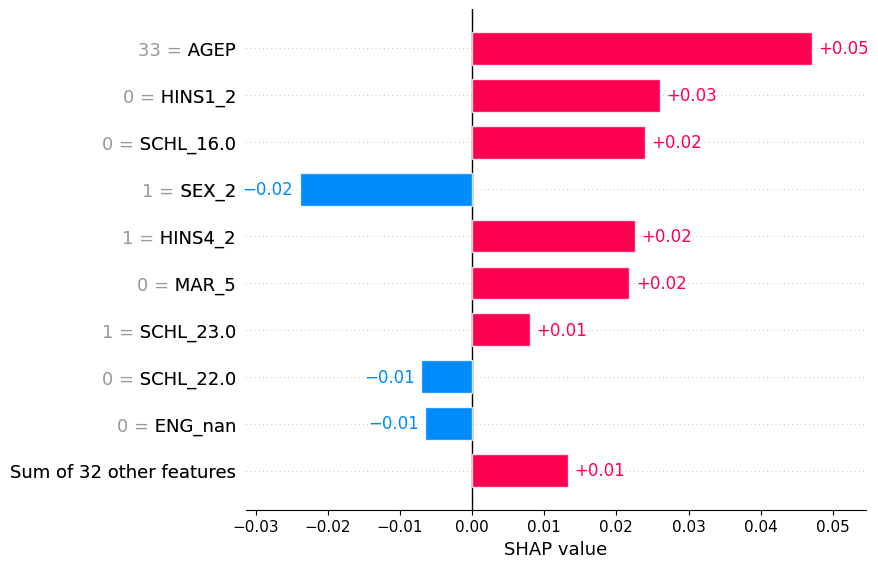

In [31]:
# Ensure correct SHAP values selection for instance 44 and class 1
shap_exp = shap.Explanation(
    values=shap_values[44, :, 1],  # SHAP values for instance 44, class 1
    base_values=base_value,  # Base value for class 1
    data=X_test.iloc[44].values,  # Ensure data is a 1D array
    feature_names=X_test.columns  # Feature names
)

# ✅ Generate SHAP bar plot
shap.plots.bar(shap_exp)


In [86]:
shap.initjs()
shap.force_plot(explainer_tree.expected_value[1], shap_values_to_plot[44])